# 3. Convolutional AutoEncoder MNIST

Reference: https://www.youtube.com/watch?v=P2lYhhCZ0Vg

## Input libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# TensorFlow
import tensorflow as tf

In [9]:
# Keras
from keras.datasets import mnist

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [10]:
# Other Libraries
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Check if GPU is available
devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(devices))

Num GPUs Available:  1


### Load Dataset

In [12]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

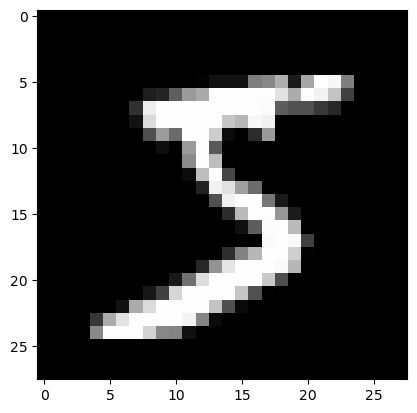

In [13]:
# Visualize one image
plt.imshow(X_train[0], cmap='gray')

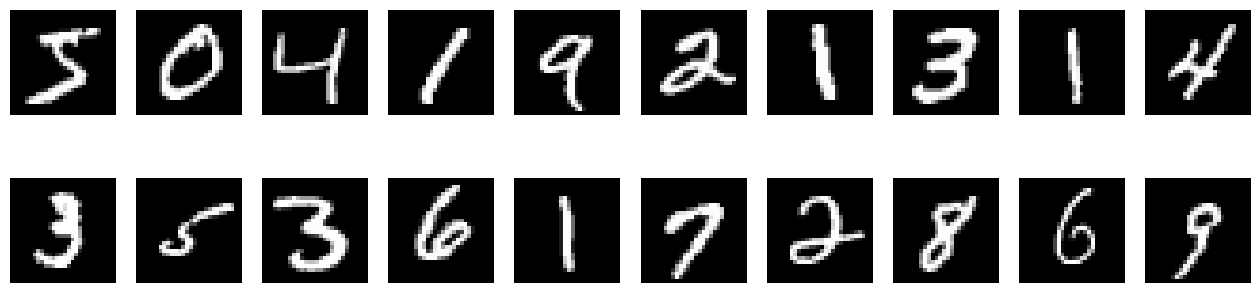

In [14]:
fig, axes = plt.subplots(2, 10, figsize=(16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i, j].imshow(X_train[count], cmap='gray')
        axes[i, j].axis('off')
        count += 1

### Preprocess the data

In [15]:
X_train[0].shape[0]

28

In [16]:
X_train.shape[0]

60000

In [17]:
28*28

784

In [18]:
X_train.shape

(60000, 28, 28)

In [19]:
X_test.shape

(10000, 28, 28)

x_train contains 60000 images of 28x28 pixels each. Now, we need to flatten the images into vectors of 28x28 = 784 pixels each. The result is that x_train will be a matrix of 6000 x 784 (28*28). We will repeat the same for x_test 10000 x 784 (28*28).

In [20]:
X_test[0].shape[1]

28

Normalize the data dividing the dataset by the max number, in this case 255.

In [21]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Check if the values are between 0 and 1.

In [22]:
X_train.max()

1.0

In [23]:
X_train.shape[0]

60000

In [24]:
X_train.shape[1]

28

### Add noise to the data

In [25]:
noise_factor = 0.1
X_train_noise = X_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [26]:
X_train_noise.shape

(60000, 28, 28)

In [27]:
X_test_noise.shape

(10000, 28, 28)

### Visualize noisy images

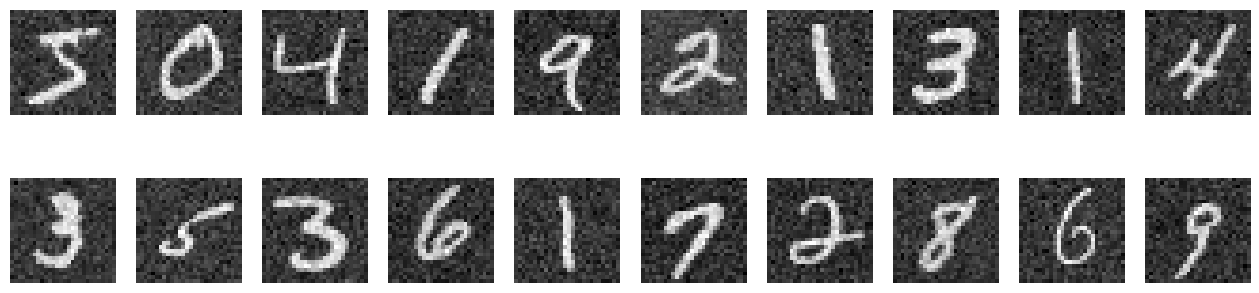

In [28]:
fig, axes = plt.subplots(2, 10, figsize=(16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i, j].imshow(X_train_noise[count], cmap='gray')
        axes[i, j].axis('off')
        count += 1

### Reshape the dataset

In [29]:
# Convert 2D image into 1D vector
X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0], X_train[0].shape[1], 1)
X_train.shape

(60000, 28, 28, 1)

In [30]:
X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[1], X_test[0].shape[1], 1)
X_test.shape

(10000, 28, 28, 1)

In [31]:
# Convert 2D image into 1D vector
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], X_train_noise[0].shape[0], X_train_noise[0].shape[1], 1)
X_train_noise.shape

(60000, 28, 28, 1)

In [32]:
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], X_test_noise[0].shape[1], X_test_noise[0].shape[1], 1)
X_test_noise.shape

(10000, 28, 28, 1)

## Model

In [33]:
X_train.shape[0]

60000

In [34]:
# Encoder Input Layer
encoder_input = Input(shape=X_train.shape[1:]) #28, 28, 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input) # (6000, 28, 28, 32)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), padding='same')(x) # (6000, 14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # (6000, 14, 14, 32)
x = BatchNormalization()(x)
encoded = MaxPool2D((2, 2), padding='same')(x) # (6000, 7, 7, 32)

2023-08-25 13:20:53.296472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-25 13:20:53.296641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-25 13:20:53.296756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [35]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded) # (6000, 7, 7, 32)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x) # (6000, 14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # (6000, 14, 14, 32)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x) # (6000, 28, 28, 32)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # (6000, 28, 28, 1)

In [50]:
# Connect Layers intop the Model
autoencoder = Model(encoder_input, decoded, name = 'Denoising_Autoencoder')
autoencoder.summary()

Model: "Denoising_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 3

In [51]:
# Compile the model using MSE loss and Adam Optimizer
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

#### Train Model

In [53]:
# Fit training data to the model
checkpoint = ModelCheckpoint('../models/MNIST/DAE_MNIST_best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)
history = autoencoder.fit(X_train_noise, X_train, epochs=50, batch_size=128,  callbacks= checkpoint, validation_split = 0.25, verbose = 2)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.07236, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
352/352 - 2s - loss: 0.0689 - val_loss: 0.0724 - 2s/epoch - 5ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.07236 to 0.06927, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
352/352 - 2s - loss: 0.0686 - val_loss: 0.0693 - 2s/epoch - 5ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.06927
352/352 - 2s - loss: 0.0684 - val_loss: 0.0694 - 2s/epoch - 5ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.06927 to 0.06861, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
352/352 - 2s - loss: 0.0683 - val_loss: 0.0686 - 2s/epoch - 5ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.06861 to 0.06858, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
352/352 - 2s - loss: 0.0680 - val_loss: 0.0686 - 2s/epoch - 5ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.06858 to 0.06827, saving model to ../models/MNIST/DAE_MNIST_best_model.h5


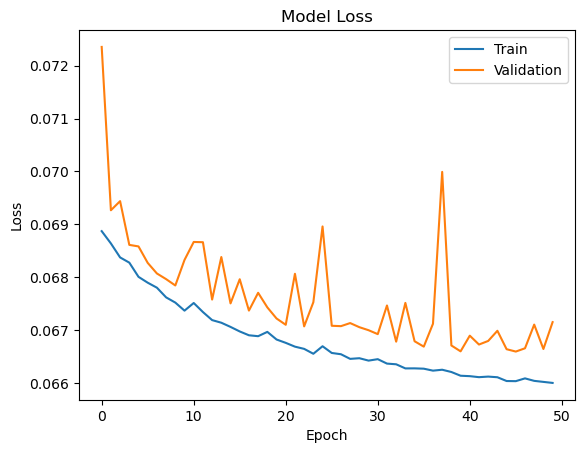

In [56]:
# Plot the training loss  and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Load BEST Model

In [58]:
from keras.models import load_model

autoencoder = load_model('../models/MNIST/DAE_MNIST_best_model.h5')
autoencoder.summary()

Model: "Denoising_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 3

#### Visualize Data

In [59]:
def visualize_data(data):
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2])
    count = 0
    fig, axes = plt.subplots(2, 10, figsize=(16, 4))
    for i in range(2):
        for j in range(10):
            axes[i, j].imshow(data[count], cmap='gray')
            axes[i, j].axis('off')
            count += 1

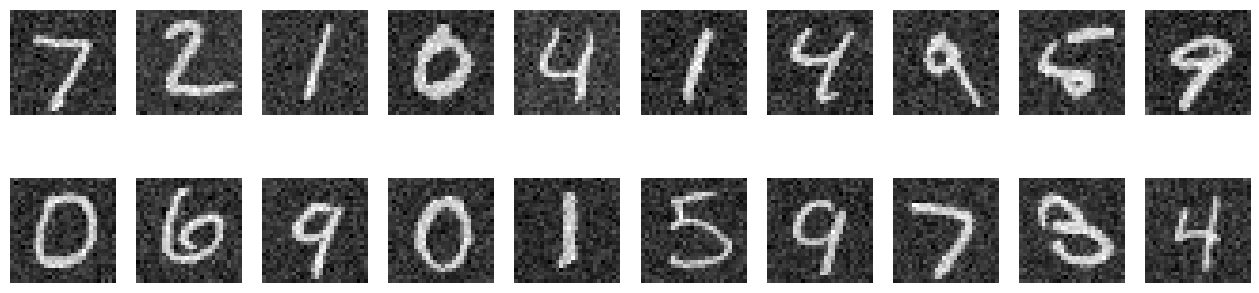

In [60]:
visualize_data(X_test_noise[:20])

In [61]:
# Predict on test noisy data
pred = autoencoder.predict(X_test_noise[:20])
pred.shape

1/1 [==============================] - 0s 145ms/step


(20, 28, 28, 1)

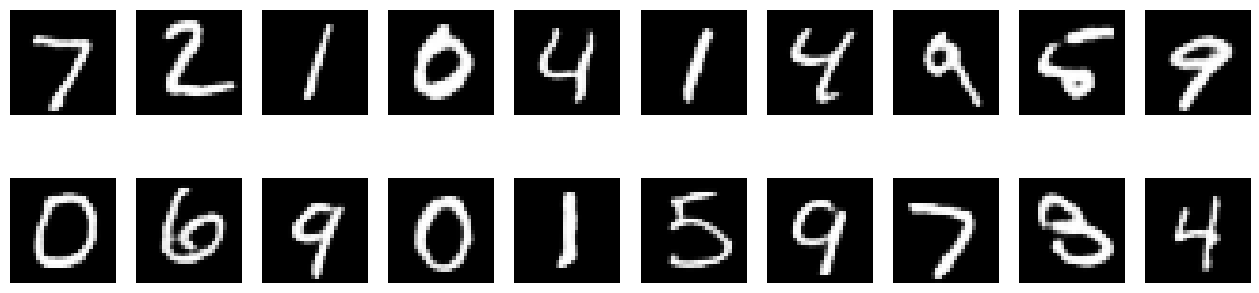

In [62]:
visualize_data(pred)